
<div style="text-align: center; font-family: 'Times New Roman'; font-size: 24pt;">
    7CCSMQMF Python Coding Coursework
</div>


<hr style="border:2px solid gray; width: 75%;">

# Introduction


#### In this Jupyter Notebook, we will be pricing:

- Asian Fixed and Floating Call and Put options:
    - With Arithmetic Averaging, 
    - Geometric Averaging, 
    - Arithmetic Averaging with variable time between averaging points
- Supershare options

### General Idea behind Monte Carlo Simulation for Option Pricing:

1. Simulate a single risk-neutral random walk starting at the initial value $S_0$ up until the time horizon. This is one realisation of the stock price's path.
2. Use the simulated stock price at maturity (the end of the time horizon) to calculate the option's payoff
3. Repeat these steps to get many (ideally thousands) of realisations.
4. Calculate the average payoff from all the realisations.
5. Finally present value this to get the fair value of the option at the current time.


[1]

## Simulating the underlying stock price:

- We will make the assumption that our underlying $S$ follows Geometric Brownian Motion, the discretised version:

<div style="text-align:center;">
 \[
  \delta S = rS\delta t + \sigma S\sqrt{\delta t}\phi
  \]
</div>

##### Equation 1

where : 
- $r$ is the risk-neutral growth rate
- $\sigma$ is the volatility
- $\phi$ is from a standardised Normal distribution.

### Euler–Maruyama Scheme:
- From [1] we have seen that for the log-normal random walk we can consider the special case $r, σ ∈ \mathbb {R} $ and apply <strong>Itô III</strong> on $V(S) = logS$
- This gives us:
<div style="text-align:center;">
 \[
  d(logS) = (r-\frac12 \sigma^2)dt + \sigma dX
  \]
</div>

- Let's integrate, and exponentiate to get rid of the log


- Now, under risk-neutral probabilities, we can simulate a path of stock prices with the equation:   
<div style="text-align:center;">
 \[
  S_T = S_0 \cdot \exp\left(\left(r - \frac{\sigma^2}{2}\right)T + \sigma \sqrt{T}Z\right) 
  \]
</div>
##### Equation 3

Where $ \sqrt{T}Z\  = X(T) $ where $Z$ is a random varialbe drawn from $N(0, 1)$ and $T$ is the time to expiry.

#### Now we can do step 1. from above.

### Importing dependencies:

In [696]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import standard_normal
from scipy.stats import gmean

### Generating the Monte-Carlo Simulation For the Underlying
- We will be simulating multiple paths of a stock price, i.e. repeating step 1. many times.

- `generate_paths()`
    - This function creates `num_paths` number of simulations, for each simulation using Equation 3 described above.  

In [697]:
def generate_paths(S0, r, sigma, T, dt, num_paths, num_steps):
    
    # Initialising a 2D array that will hold the simulations.
    
    paths = np.zeros((num_paths, num_steps + 1))
    
    
    # For the first value in each simulation, set it to the initial stock price.
    
    paths[:, 0] = S0
    
    
    # For each step, use Equation 3 to generate the next stock price.
    
    for i in range(1, num_steps + 1):
        
        
        # Generate a random increment for each step,
        
        Z = np.random.normal(0, np.sqrt(dt), num_paths)
        
        
        # Here making use of Equation 3 for each time step.
        
        paths[:, i] = paths[:, i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * Z)

    
    # Returning the paths generated.
        
    return paths


### Let's have a look at the Simulation:

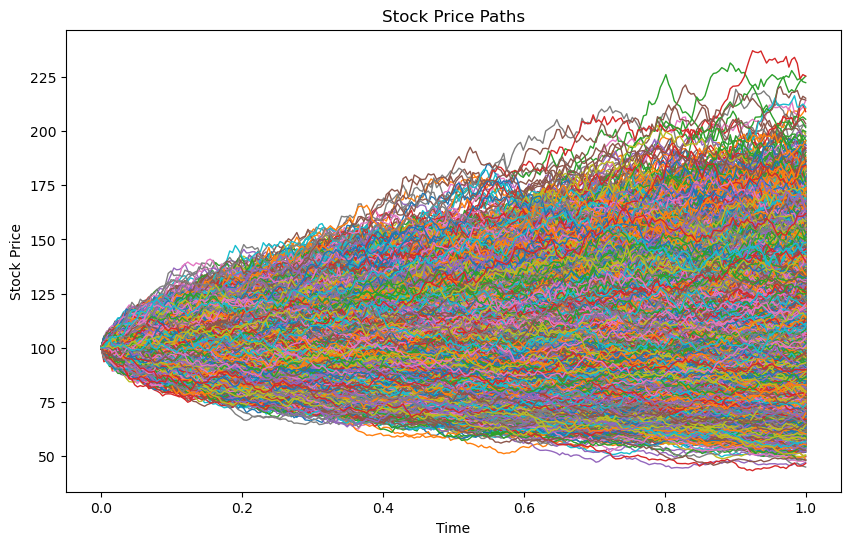

In [698]:
# Parameters

S0 = 100          # Initial stock price
r = 0.05          # Risk-free rate
sigma = 0.2       # Volatility
T = 1.0           # Time to maturity
num_paths = 40000 # Number of simulations
num_steps = 252   # Number of time steps
K_fixed = 100     # Fixed strike for Asian fixed strike option

# Calculating the time step
dt = T / num_steps


# Generating the paths

stock_paths = generate_paths(S0, r, sigma, T, dt, num_paths, num_steps)



# Plot stock price paths

plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_steps + 1) * dt, stock_paths.T, lw=1)
plt.title('Stock Price Paths')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

This is a general Monte-Carlo simulation that is quite common to see online. Each path is a realisation of a stock price following Geometric Brownian Motion.

## Let's consider the way we take averages of the stock price
- This is important for Asian option's payoffs.
- We will visualise this for one individual path from the above simulation


### There are two methods we will use:
1. The first is averaging making use of every single day's stock data in a given simulation. For example, this can be done with `np.mean(sims, axis=1)` on the stock simulations array.
    - For this method, we can do Arithmetic averaging and Geometric averaging, which will be explained under Calculating Option Prices below, where we define the methods.<br>
<br>
2. The second is using `special_average()` on the stock prices, this calculates the average like described below:

#### Using the `special_average` function, we calculate the arithmetic average with a Time between Averaging Points. 
#### (As described on Slide 14 [2])

Consider we have $t$ as the daily step in generated stock price, $t=0$ is the first day, $t=1$ is the second day, and so on up to expiry $t=T$.

Let's now take $τ_n$ points across $t$, so $τ_1$ is the first point, $τ_2$ is the second point, and so on. These will be equally spaced across (with size =Time Between Averaging Step) our initial timeline $t$.

To take the `special_average` we will in essence:

With initial stock $S_0 = 100$
- Take the first average $A_1$ at $τ_1$, $S_0=100$, $A_1=S_0$
    - So our first average is just equal to initial stock price
- The second average $A_2$ = $average(S_{τ_2}, A_1)$
    - This is the average of (the first average + stock price at ${τ_2}$ (i.e. $S_{τ_2}$) )
- The third average $A_3$ = $average(S_{τ_3}, A_2)$
    - and so on, until

- The final average $A_f$ = $average(S_{τ_n}, A_{n-1})$

We will use this final average as our average of an individual stock price simulation.


### Below is the `special_average_visualise` function to show how the averaging works:

- This shows how we take the average on a single simulation of the stock price (we will simply look at the first simulation at index 0.
    - Later we modify this function to work on the whole array of simulations

In [699]:
def special_average_visualise(paths, averaging_step):
        
        
    stock_prices = paths[0, :]
    
    
    # Set the number of days for the gap
    
    n = averaging_step 

    
    # Initialize the special averages array with the first stock price
    
    special_averages = [stock_prices[0]]

    
    # Calculate the special averages with n-day gaps
    
    for i in range(1, len(stock_prices) // n + 1):
        index = i * n
        previous_average = (special_averages[-1] + stock_prices[index]) / 2
       
        
        special_averages.append(previous_average)


    
    
    #         Plotting:

    
    # Determining the number of time steps
    
    num_time_steps = len(special_averages)

    
    # Create an array for x values (time steps)
    
    x_values = np.arange(0, num_time_steps)

    
    fig = plt.figure(figsize=(12, 10))
    plt.plot(stock_prices)
    
    
    # Plotting the horizontal lines with specified ranges
    
    for i, value in enumerate(special_averages):
        start = i * n
        end = (i + 1) * n
        plt.hlines(value, xmin=start, xmax=end, colors='blue', linestyles='solid', label=f'Line {i + 1}')
        
        
        # Ploting vertical lines connecting consecutive horizontal lines
        
        plt.vlines(end, ymin=special_averages[i], ymax=special_averages[i+1], colors='green', linestyles='dashed')
        
        
        
    # Seting the labels and title
    
    
    plt.xlabel('Time Steps')
    plt.ylabel('Values on Y Axis')
    plt.title('Multiple Horizontal Lines Plot')

    # Show the plot
    plt.show()
    
    

### Here is the normal averaging we described as the first method (1.) with arithmetic averaging.
- Taking the average of every day in the stock price simulation.

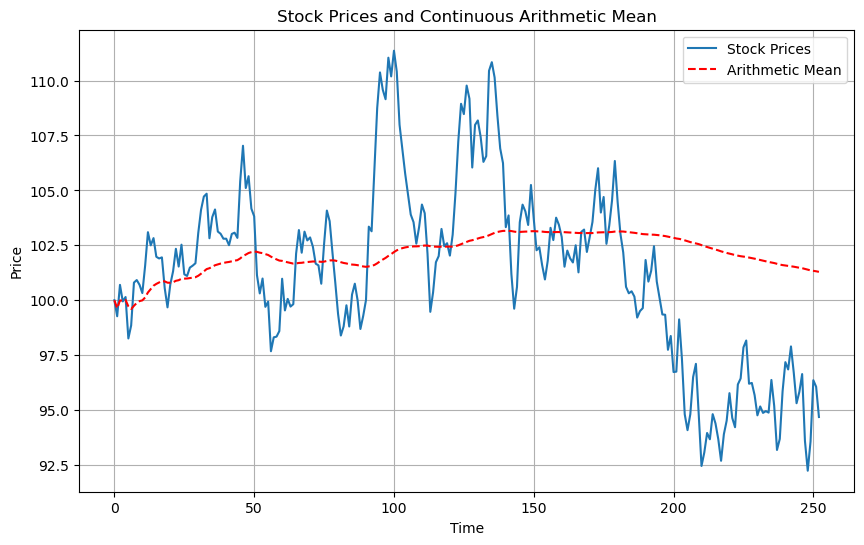

In [701]:
# stock_paths = generate_paths(S0, r, sigma, T, dt, num_paths, num_steps)



paths = stock_paths[0, :]
stock_prices = stock_paths[0, :]


# Calculate the continuous arithmetic mean
arithmetic_mean = np.cumsum(stock_prices) / np.arange(1, len(stock_prices) + 1)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(stock_prices, label='Stock Prices')
plt.plot(arithmetic_mean, label='Arithmetic Mean', linestyle='--', color='red')
plt.title('Stock Prices and Continuous Arithmetic Mean')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()




This is typicall what you will see when you look for a Stock price plotted with its arithmetic mean.

### This is the special_average function, described as the second method (2.).

##### Note: You can ignore the error messages from matplotlib, it is trying to plot a vertical line at the very last point, however there is nothing to connect it to.
##### Additionally, I couldn't figure out how to cut off the final horizontal line, so it carries on past the last simulated value, however this should just be a visualising error (more pronounced in averging_step = 20 example).  

#### Starting with an averaging step of size 2

IndexError: list index out of range

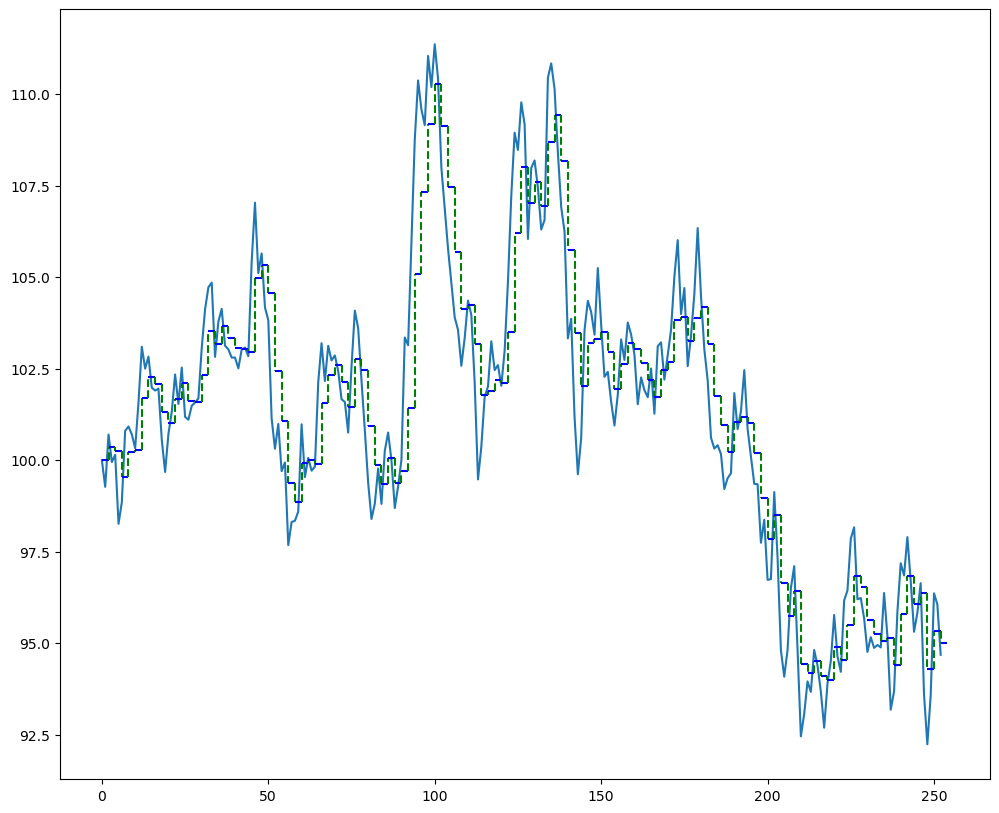

In [702]:
averaging_step = 2

special_average_visualise(stock_paths, averaging_step)

#### Now the average stepping size is 20.

IndexError: list index out of range

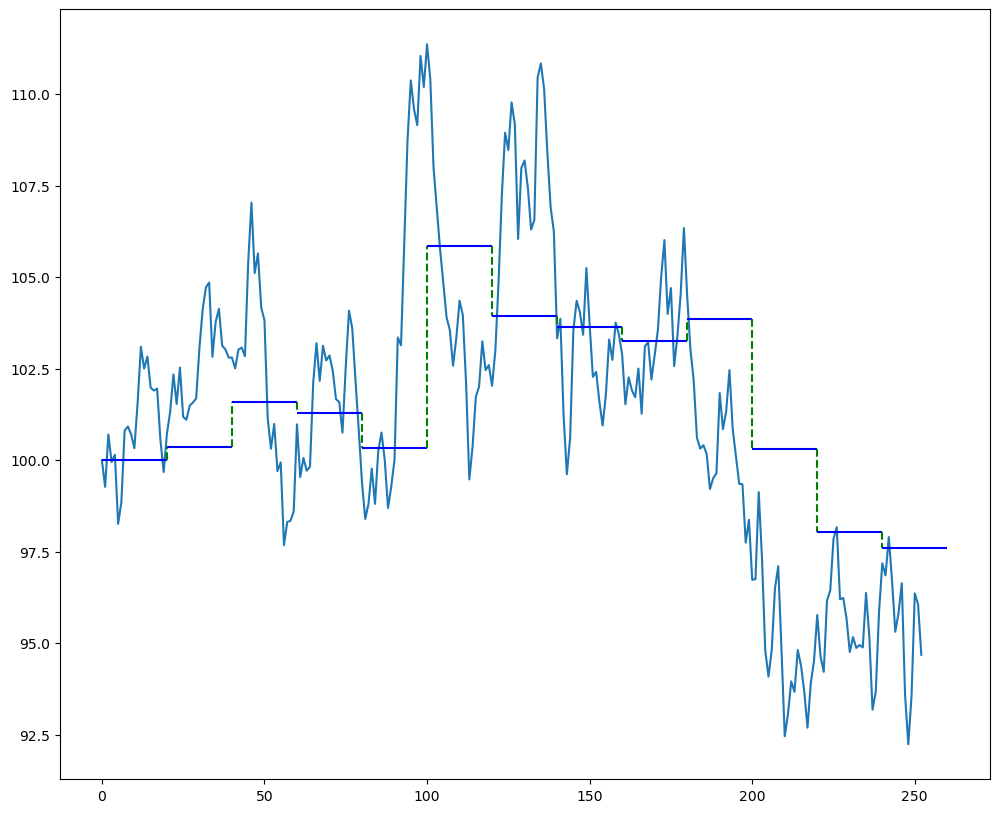

In [703]:
averaging_step = 20

special_average_visualise(stock_paths, averaging_step)

## Discussion:

- With a stepping size of 20, we get a similar picture to that of Slide 14 [2].
- Comparing the point of the final average, both methods (normal mean and special average for 2 and 20 step) reach a final mean which is similar.
    - Due to the nature of taking larger stepping values, we will tend to be further away from the normal mean (first method)

# Calculating Option prices

### From the Introduction, we now want to complete steps 2. to 5.

 We will be finding the options price $V(S, t)$ using the expected value of the discounted payoff under the risk-neutral density ℚ:

<div style="text-align:center; font-size: 1.2em;">
 \[
  V(S, t) = \exp\left\{-r(T-t)\right\} \mathbb{E}^{\mathcal{Q}}[\text{Payoff}(S_T)]
 \]
</div>

Doing the above for multiple realisations, concludes steps 2. to 5., in the Introduction, giving us the value of the option.

The only thing left for us to do is calculating each type of option's payoff, based off the simulations, and finally present valuing.

### Asian Fixed-Strike Options
- Their payoffs are defined:
<div style="text-align:center; font-size: 1.05em;">
 \[
  \text{Payoff}_{call} = max(A(0, T) - K, 0)
 \]
</div>

<div style="text-align:center; font-size: 1.05em;">
 \[
     \text{Payoff}_{put} = max(K - A(0, T), 0)
 \]
</div>

Where the averaging:

- Letting $t_i$ = $i ⋅ (T/n)$ for $i ∈ {0, 1, 2, ... ,n}$

#### Arithmetic:
<div style="text-align:center; font-size: 1.05em;">
 \[
     A(0, T) = \frac1 n  \sum_{i=0}^{n-1}S_{t_i}
 \]
</div>

#### Geometric:

<div style="text-align:center; font-size: 1.05em;">
 \[
     A(0, T) = \left(\prod_{i=0}^{n-1} S_{t_i}\right)^{\frac{1}{n}}
 \]
</div>
[3]

#### Special case:
We will use the recursive relation that we described under the Introduction:<br>
<br>
Recalling, $A_f$ was the final average, this is what we will feed into $A(0, T)$:<br>
<br>

<div style="text-align:center; font-size: 1.05em;">
    \[
    A_f = \text{average}(S_{\tau_n}, A_{n-1})
    \]
</div>


#### Below is the code for computing the Special averaging:
- An explanation of how this works is under the title: Let's consider the way we take averages of the stock price, below the Introduction.


In [704]:
def special_average_test2(paths, averaging_step):
    
    last_special_averages = []

    
    for i in range(num_paths):
    
        stock_prices = paths[i, :]    
        
        
        # Set the number of days for the gap
        
        n = averaging_step  
        
        
        # Initialising the averages array with the first stock price
        
        special_averages = [stock_prices[0]]
        
        
        # Calculate the averages with n-day gaps
        
        for j in range(1, len(stock_prices) // n + 1):
            
            
            # Increasing the index by n (averaging_step)
            
            index = j * n
            
            
            # Finding the average between the price in n day times and now.
            
            previous_average = (special_averages[-1] * j + stock_prices[index]) / (j + 1)
        
            
            # Appending to our list.
            
            special_averages.append(previous_average)
        
        
        # For the purposes of options pricing, we only need the last average (A_f described earlier)
        
        last_special_average=special_averages[-1]
        last_special_averages.append(last_special_average)

 
    return np.array(last_special_averages)

### Now we want to use the above payoffs defined, to calculate the Asian Fixed Strike options prices

In [585]:
def asian_fixed_strike_option(paths, K, call_put, averaging_step, mean_gmean='gmean'):
    
    
    # Check whether we are using normal averaging, considering every days stock price. (arithmetic or geometric)
    
    if averaging_step == 1:
        
        
        # Arithmetic averaging
        
        average_price = np.mean(paths, axis=1)
        
        
        # Check if we are using a geometric averaging
        
        if mean_gmean == 'gmean':
            
            
            # Geometric averaging       (gmean from scipy.stats)
            
            average_price = gmean(paths, axis=1)
        
    
    # If we are doing an arithmetic average with a Time Between Averging Points (i.e. special averaging)
    
    elif averaging_step > 1:
        
        
        # Computing the special average
        
        average_price = special_average_test2(paths, averaging_step)
        
    
    # For a call
    
    if call_put == 'call':
        
        
        # Computing payoff like defined above for call
        
        payoff = np.maximum(average_price - K, 0)
    
    
    # For a put
        
    elif call_put == 'put':
        
        
        # computing payoff like defined above for a put
        
        payoff = np.maximum(K - average_price, 0)
    
    
    # Discounting the payoff
    
    discounted_payoff = np.exp(-r * T) * payoff
    
    
    # Finding the average of all discounted payoffs, giving us the Option Price.
    
    option_price = np.mean(discounted_payoff)

    
    # Returning Option Price.
    
    return option_price


S0 = 100
K_fixed = 100
T=1
sigma=0.2
r=0.05

# Generate paths
stock_paths = generate_paths(S0, r, sigma, T, dt, num_paths, num_steps)

# Calculate Asian option prices
asian_fixed_strike_call_price = asian_fixed_strike_option(stock_paths, K_fixed, call_put='call',
                                                         averaging_step=1, mean_gmean='gmean')
asian_fixed_strike_put_price = asian_fixed_strike_option(stock_paths, K_fixed, call_put='put',
                                                        averaging_step=1, mean_gmean='gmean')

# Print results
print("Asian Fixed Strike Call Option Price:", asian_fixed_strike_call_price)
print("Asian Fixed Strike Put Option Price:", asian_fixed_strike_put_price)

Asian Fixed Strike Call Option Price: 5.566520885626912
Asian Fixed Strike Put Option Price: 3.427207966818101


Above results as sanity check.

### Asian Floating-Strike Options

Asian Floating-Strike Options have a slightly different payoff.

- Their payoffs are defined:
<div style="text-align:center; font-size: 1.05em;">
 \[
  \text{Payoff}_{call} = max(S(T) - A(0, T), 0)
 \]
</div>

<div style="text-align:center; font-size: 1.05em;">
 \[
     \text{Payoff}_{put} = max(A(0, T) - S(T), 0)
 \]
</div>

#### $A(0, T)$ exhibits the same averaging as before, so we will not redefine it.

In [705]:
def asian_floating_strike_option(paths, call_put, averaging_step, mean_gmean):
    
    
    # Check whether we are using normal averaging, considering every days stock price. (arithmetic or geometric)

    if averaging_step == 1:
        
        
        # Arithmetic averaging
        
        average_price = np.mean(paths, axis=1)
        
        
        # Check if we are using a geometric averaging
        
        if mean_gmean == 'gmean':
            
            
            # Geometric averaging       (gmean from scipy.stats)
            
            average_price = gmean(paths, axis=1)
    
    
    
    
    
    
    
    # If we are doing an arithmetic average with a Time Between Averging Points (i.e. special averaging)
    
    elif averaging_step > 1:
        
        
        # Computing the special average
        
        average_price = special_average_test2(paths, averaging_step)

    
    # For a call
        
    if call_put == 'call':
        
        
        # Computing payoff like defined above for call
        
        payoff = np.maximum(paths[:, -1] - average_price, 0)
    
    
    # For a put
    
    elif call_put == 'put':
        
        
        # Computing payoff like defined above for put.
        
        payoff = np.maximum(average_price - paths[:, -1], 0)
    
    
    # Discounting all the payoffs for present value
    
    discounted_payoff = np.exp(-r * T) * payoff
    
    
    # Taking the average which gives us the Option Price
    
    option_price = np.mean(discounted_payoff)
    
    
    # Returning Option Price
    
    return option_price


In [706]:
stock_paths = generate_paths(S0, r, sigma, T, dt, num_paths, num_steps)


asian_floating_strike_call_price = asian_floating_strike_option(stock_paths, call_put='call',
                                                             averaging_step=1, mean_gmean='gmean')

asian_floating_strike_put_price = asian_floating_strike_option(stock_paths, call_put='put',
                                                           averaging_step=1, mean_gmean='gmean')

print("call: ", asian_floating_strike_call_price)
print("put: ", asian_floating_strike_put_price)

0.003968253968253968
call:  6.154679164809309
put:  3.2755021967338247


Above results as sanity check.

## Super Share Options

A Super share has a payoff:


<div style="text-align:center; font-size: 1.05em;">
    \[
    \text{Payoff}_{SS} = \frac{S_T}{K_1} \cdot 1_{\left\{K_1 < S_T < K_2\right\}}
    \]
</div>

[4]


Where $K_1$ is the lower boundary, $K_2$ is the upper boundary

The Identity function (1) is true when $S_T$ is inbetween the two boundaries( i.e. $K_1 < S_T < K_2$), in this case the identity function is set to 1, and thus the payoff is simply $\frac{S_T}{K_1}$.

In the case that $S_T$ is not inbetween $K_1$ and $K_2$ , then the identity function is set to 0, and the payoff of the supershare option is 0.


Knowing the payoff, now we can dive into the code:

In [708]:
def supershare_option_price(paths, KL, KH):
    
    
    # Initialise an array to store option payoffs for each path and each time step
    
    option_payoffs = np.zeros_like(paths)
    
    
    # Iterate over each path to calculate option payoffs
    
    for i in range(paths.shape[1]):
        
        
        # Applying the payoff described above, we need to check the two boundaries
        
        option_payoffs[:, i] = np.where(paths[:, i] >= KH, 0, np.where(paths[:, i] < KL, 0, paths[:, i] / KL))
    
    
    # We can now calculate the average of the payoffs
    
    option_prices = np.mean(option_payoffs[:, -1])
    
    
    # And finally discount to get the Option's Price.
    
    option_prices = np.exp(-r * T) * option_prices

    
    # Returning the option price.
    
    return option_prices




# Results

### Let's start off by looking at the payoff diagram for a Supershare option which is rather interesting and simple.

We will first create a function to only calculate the payoff of a Supershare option.
- We will then generate some example stock price values, and two boundaries.
- After calculating the payoff for these at different values for the stock price, we will plot this.
    - We will plot vertical lines to show the theoretical boundaries, and we will superimpose the payoff. 

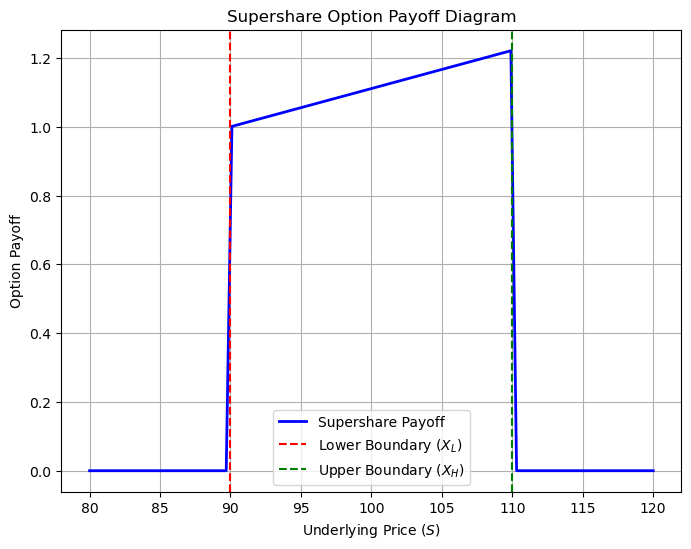

In [709]:
def supershare_payoff(S, XL, XH):
    
    
    # Simple payoff function
    
    return np.where((S >= XL) & (S <= XH), S / XL, 0)


# Example parameters for visualisation

XL = 90
XH = 110
stock_price_examples = np.linspace(80, 120, 100)


# Calculate Supershare option payoffs

payoffs = supershare_payoff(stock_price_examples, XL, XH)


# Plot the payoff diagram

plt.figure(figsize=(8, 6))
plt.plot(S_values, payoffs, label='Supershare Payoff', color='blue', linewidth=2)
plt.axvline(XL, color='red', linestyle='--', label='Lower Boundary ($X_L$)')
plt.axvline(XH, color='green', linestyle='--', label='Upper Boundary ($X_H$)')


# Adding labels and a title

plt.title('Supershare Option Payoff Diagram')
plt.xlabel('Underlying Price ($S$)')
plt.ylabel('Option Payoff')
plt.legend()
plt.grid(True)
plt.show()

#### Discussion:

- We can clearly see that outside the boundaries, the payoff is 0.
- Looking at when $S=91$, we just pass the lower boundary:
    - Now we are experiencing a payoff, $\frac{S_T}{K_1}$. 
    - Increasing the value of $S$, we get a larger payoff, this is due to the fraction's numerator getting larger ($S$ increasing) and the denominator (lower boundary $X_L$) staying the same.
        - This gives us the inclined slop from 90 to 110.
    - Now getting to the upper boundary ($X_H$), the payoff cuts off after this as per the option's payoff equation.



In [617]:
# Setting parameters:

S0 = 100  # Initial stock price
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
T = 1.0  # Time to maturity
num_paths = 40000  # Number of simulations
num_steps = 252  # Number of time steps
K_fixed = 100  # Fixed strike for Asian fixed strike option

# Calculate time step
dt = T / num_steps


# Generate paths
stock_paths = generate_paths(S0, r, sigma, T, dt, num_paths, num_steps)

## Asian Fixed vs Floating Strike and Put vs Call.

We want to see if Floating Asian options are more expensive than Fixed Asian options and the difference in price between Puts and Calls.

In [710]:
def first_visualisation(stock_paths):
    
    stock_paths = stock_paths
    
    # Calculate Asian fixed option prices with averaging step = 1
    
    asian_fixed_strike_call_price = asian_fixed_strike_option(stock_paths, K_fixed, call_put='call',
                                                             averaging_step=1, mean_gmean='mean')
    asian_fixed_strike_put_price = asian_fixed_strike_option(stock_paths, K_fixed, call_put='put',
                                                            averaging_step=1, mean_gmean='mean')

    # Calculate Asian floating option prices with averaging step = 1
    
    asian_floating_strike_call_price = asian_floating_strike_option(stock_paths, call_put='call',
                                                                  averaging_step=1, mean_gmean='mean')
    asian_floating_strike_put_price = asian_floating_strike_option(stock_paths, call_put='put',
                                                                 averaging_step=1, mean_gmean='mean')

    #         Plotting
    
    options_fixed = ['Asian Fixed Strike Call', 'Asian Fixed Strike Put']
    option_prices_fixed = [asian_fixed_strike_call_price, asian_fixed_strike_put_price]

    options_floating = ['Asian Floating Strike Call', 'Asian Floating Strike Put']
    option_prices_floating = [asian_floating_strike_call_price, asian_floating_strike_put_price]

    plt.figure(figsize=(10, 6))

    
    # Plotting Asian fixed option prices
    
    plt.bar(options_fixed, option_prices_fixed, color=['blue', 'orange'])
    plt.bar(options_floating, option_prices_floating, color=['green', 'red'])

    plt.title('Asian Option Prices with Averaging Step = 1')
    plt.xlabel('Option Type')
    plt.ylabel('Option Price')

    # Adding some text labels to each bar containing the option price.
    
    for bar, price in zip(plt.bar(options_fixed, option_prices_fixed, color=['blue', 'orange']).patches, option_prices_fixed):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{price:.2f}', ha='center', va='bottom')

    for bar, price in zip(plt.bar(options_floating, option_prices_floating, color=['green', 'red']).patches, option_prices_floating):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{price:.2f}', ha='center', va='bottom')

        
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.show()
    

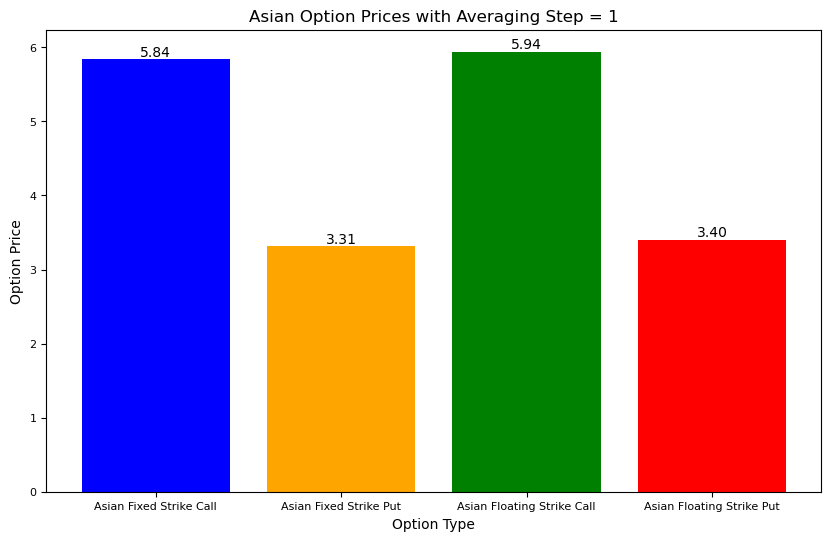

In [711]:
first_visualisation(stock_paths)

#### Results Discussion:

We can see that the Fixed options are slightly cheaper than Floating options.
- This is due to the associated risk with Floating strike options resulting in a Risk Premium, and you pay for the risk.
    - The risk comes from the fact that the Floating options have the strike as the final stock price ($S_T$) which is variable. And with variability comes uncertainty resulting in a risk premium.

It should be noted that these are simulated stock prices in a risk-neutral world, it could be in the live markets that Floating Asians might be more in demand resulting in a higher price, but this is out of our scope.

#### Another Discussion topic:

It's also clearly visible that in both cases, the put options are cheaper than the call options.

- The reasoning behind this is that we are simulating our stock prices in a risk-neutral world (see equation 3) which has a positive drift, r which is the risk-free rate. Our final stock prices $S_T$ will therefore tend to be higher in the future, so our calls will tend to be in-the-money more often.
    - The call gives a right to buy the option at a strike of 100, and if the average stock price grows with the risk-free rate to $S_T>100$, then you can buy for 100 at expiry and sell them at the current price leading to profits.

### Let's try with a negative risk-free rate instead
#### - This should make the calls cheaper than the puts, because the average stock price will be decreasing.

In [717]:
# Setting parameters:

S0 = 100  # Initial stock price
r = -0.05  # Risk-free rate
sigma = 0.2  # Volatility
T = 1.0  # Time to maturity
num_paths = 40000  # Number of simulations
num_steps = 252  # Number of time steps
K_fixed = 100  # Fixed strike for Asian fixed strike option

# Calculate time step
dt = T / num_steps


# Generate paths
stock_paths_negative_r = generate_paths(S0, r, sigma, T, dt, num_paths, num_steps)

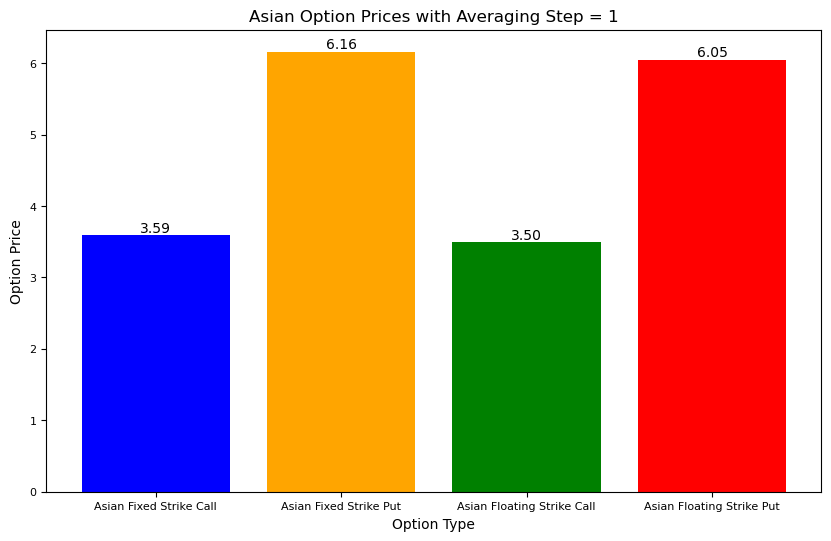

In [718]:
first_visualisation(stock_paths_negative_r)

#### Results Discussion:

We have proved our hypothesis, that now the puts are more expensive than the calls. This has the same reasoning as before, the puts now tend to be in-the-money more.

## Comparing Asian Fixed and Floating options with varying Time Between Averaging Points.

We want to see what the difference is between arithmetic averaging and using the special average we defined earlier.
- Note this special type of averaging is preferred in industry as you don't need to validate as many stock prices to compute the average, instead of using every single day of prices (in the basic arithmetic averaging), you can use e.g 1 day from a month.



#### Let's use matplotlib to show the difference between the option prices for the different averaging steps.

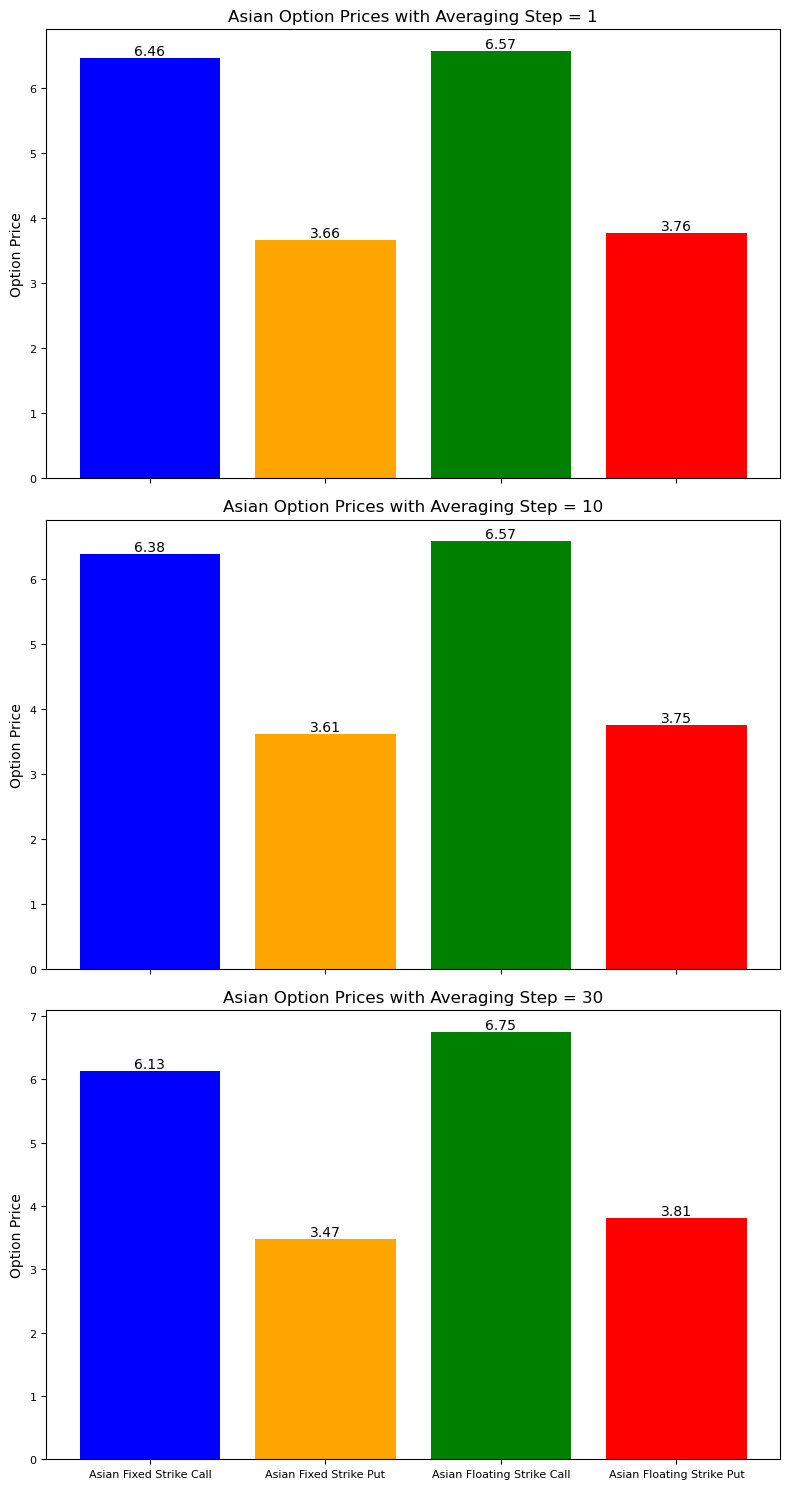

In [719]:
# Initialize lists to store results

options = ['Asian Fixed Strike Call', 'Asian Fixed Strike Put', 'Asian Floating Strike Call', 'Asian Floating Strike Put']


# Setting different averaging intervals.

averaging_steps = [1, 10, 30]


# Storing the option prices for averaging steps

option_prices = {step: [] for step in averaging_steps}


# Using our defined functions to calculate option prices.

for step in averaging_steps:
    
    
    asian_fixed_strike_call_price = asian_fixed_strike_option(stock_paths, K_fixed, call_put='call',
                                                             averaging_step=step, mean_gmean='mean')
    asian_fixed_strike_put_price = asian_fixed_strike_option(stock_paths, K_fixed, call_put='put',
                                                            averaging_step=step, mean_gmean='mean')
    asian_floating_strike_call_price = asian_floating_strike_option(stock_paths, call_put='call',
                                                                   averaging_step=step, mean_gmean='mean')
    asian_floating_strike_put_price = asian_floating_strike_option(stock_paths, call_put='put',
                                                                  averaging_step=step, mean_gmean='mean')

    option_prices[step].extend([asian_fixed_strike_call_price, asian_fixed_strike_put_price,
                                asian_floating_strike_call_price, asian_floating_strike_put_price])


    
#                Plotting:


# We want to plot 3 bar graphs.

fig, axes = plt.subplots(len(averaging_steps), 1, figsize=(8, 15), sharex=True)


# For every averaging step (ie the 3 var graphs.)

for i, step in enumerate(averaging_steps):
    
    
    # Choosing the correct axis and giving them different colours and titles.
    
    ax = axes[i]
    prices = option_prices[step]
    bars = ax.bar(options, prices, color=['blue', 'orange', 'green', 'red'])
    ax.set_title(f'Asian Option Prices with Averaging Step = {step}')
    ax.set_ylabel('Option Price')

    
    # Add the option price as a text label to see exact prices.
    
    for bar, price in zip(bars, prices):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{price:.2f}', ha='center', va='bottom')

        
# Adjusting font size to see easier

for ax in axes:
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()


#### Discussion:

- We can see that the difference between the option's prices for different Time Between Averaging Steps (averaging intervals) is relatively small. 
    - The Asian Fixed Strike Call and Put tend to slightly decrease in value for larger averaging intervals while the Asian Floating Strike Call and Put slightly increase in value. But overall fairly negligent differences.
        - Further investigation needs to be done to find a cause, but it likely has something to do with the Fixed payoff containing strike $K$ and floating containing last stock price $S(T)$

- Back to the main point that the prices stay relatively similar.
    - This indicates that it is possible to average Asian options with larger averaging intervals, keeping a similar price and behavior of the option.

This has a great benefit, the writer of the option doesn't need to validate everydays stock price, they can specify in the contract that an averaging step of 30 will be taken. Therefore out of 1 month, he only needs to validate 1 day of stock price data for the underlying. This saves time, money, resources, and also reduces the likeliness of disputes between the buyer of the contract as well.

# Supershare Options

In [720]:
# Paramaters 

s0 = 100
KL = 90
KH = 110
T = 0.25
r = 0.02
sigma = 0.20
num_paths = 10000
num_steps = 252  # Number of time steps

dt = T / num_steps


stock_paths_supershare = generate_paths(S0, r, sigma, T, dt, num_paths, num_steps)

supershare_option_price(stock_paths_supershare, KL, KH)

0.7455966054276226

We have used the website [https://www.frontsolutions.co.uk/SuperShare.htm], which is an option pricing calculator, to compare our supershare pricing function with theirs.
Using the same paramaters, we result in a very similar option price, with the minute differences being due to a matter of simulation error.

#### Let's try to increase the size of the barrier

In [721]:
s0 = 100
KL = 60
KH = 140
T = 0.25
r = 0.02
sigma = 0.20
num_paths = 10000
num_steps = 252  # Number of time steps

dt = T / num_steps


stock_paths_supershare = generate_paths(S0, r, sigma, T, dt, num_paths, num_steps)

supershare_option_price(stock_paths_supershare, KL, KH)

1.6668216553558641

#### Results Discussion

Due to the barrier being larger, we result in a more valuable option, this is because the final stock price $S_T$ is more likely to fall in this gap

### Going back to the original parameters, lets try increasing only volatility.

In [722]:
# Paramaters 

s0 = 100
KL = 90
KH = 110
T = 0.25
r = 0.02
sigma = 0.80
num_paths = 10000
num_steps = 252  # Number of time steps

dt = T / num_steps


stock_paths_supershare = generate_paths(S0, r, sigma, T, dt, num_paths, num_steps)

supershare_option_price(stock_paths_supershare, KL, KH)

0.21478437840038164

#### Results Discussion

The volatility now at 80% (which is very high) results in a cheaper option. The original price was around 0.75, now we are around 0.22.
- Due to a higher volatility, the realisations behave more chaotically. Many of these will result in final stock prices $S_T$ that are very far from the opening of the barriers, which are close to the initial price. So more of the realisations will result in out-the-money outcomes.


# Comparing Geometric mean to Arithmetic mean

Using the same parameters, lets see how the prices of options for Asians are affected by the two mean approaches.

##### Note: we will be considering averaging_step=1 as the special_average function hasn't been implemented for geometric mean.

In [723]:
# Setting parameters:

S0 = 100  # Initial stock price
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
T = 1.0  # Time to maturity
num_paths = 40000  # Number of simulations
num_steps = 252  # Number of time steps
K_fixed = 100  # Fixed strike for Asian fixed strike option

# Calculate time step
dt = T / num_steps


# Generate paths
stock_paths = generate_paths(S0, r, sigma, T, dt, num_paths, num_steps)

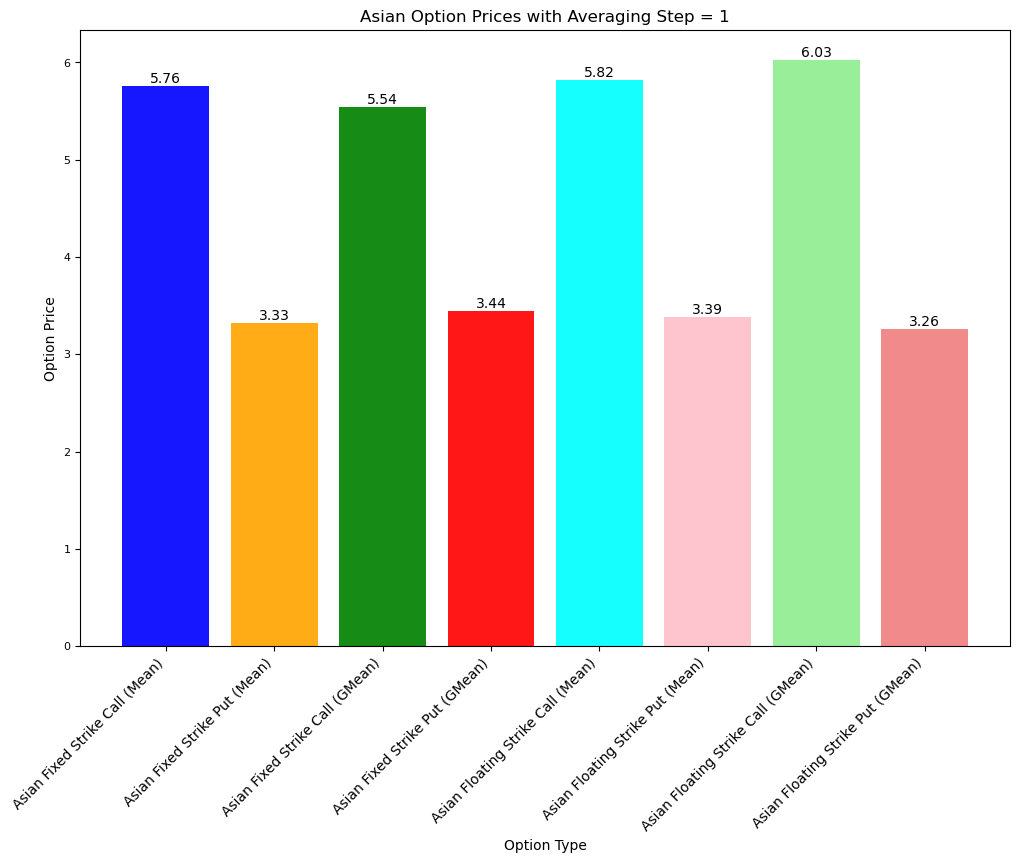

In [724]:
def second_visualisation(stock_paths):
    
    paths = stock_paths
    
    
    # Calculate Asian fixed option prices with averaging step = 1 and mean_gmean='mean'
    
    asian_fixed_strike_call_price_mean = asian_fixed_strike_option(paths, K_fixed, call_put='call',
                                                                   averaging_step=1, mean_gmean='mean')
    asian_fixed_strike_put_price_mean = asian_fixed_strike_option(paths, K_fixed, call_put='put',
                                                                  averaging_step=1, mean_gmean='mean')

    
    # Calculate Asian fixed option prices with averaging step = 1 and mean_gmean='gmean'
    
    asian_fixed_strike_call_price_gmean = asian_fixed_strike_option(paths, K_fixed, call_put='call',
                                                                    averaging_step=1, mean_gmean='gmean')
    asian_fixed_strike_put_price_gmean = asian_fixed_strike_option(paths, K_fixed, call_put='put',
                                                                   averaging_step=1, mean_gmean='gmean')

    
    # Calculate Asian floating option prices with averaging step = 1 and mean_gmean='mean'
    
    asian_floating_strike_call_price_mean = asian_floating_strike_option(paths, call_put='call',
                                                                        averaging_step=1, mean_gmean='mean')
    asian_floating_strike_put_price_mean = asian_floating_strike_option(paths, call_put='put',
                                                                       averaging_step=1, mean_gmean='mean')

    
    # Calculate Asian floating option prices with averaging step = 1 and mean_gmean='gmean'
    
    asian_floating_strike_call_price_gmean = asian_floating_strike_option(paths, call_put='call',
                                                                         averaging_step=1, mean_gmean='gmean')
    asian_floating_strike_put_price_gmean = asian_floating_strike_option(paths, call_put='put',
                                                                        averaging_step=1, mean_gmean='gmean')

    
    #             Plotting
    
    options_fixed = ['Asian Fixed Strike Call (Mean)', 'Asian Fixed Strike Put (Mean)',
                     'Asian Fixed Strike Call (GMean)', 'Asian Fixed Strike Put (GMean)']

    option_prices_fixed = [
        asian_fixed_strike_call_price_mean, asian_fixed_strike_put_price_mean,
        asian_fixed_strike_call_price_gmean, asian_fixed_strike_put_price_gmean
    ]

    
    options_floating = ['Asian Floating Strike Call (Mean)', 'Asian Floating Strike Put (Mean)',
                        'Asian Floating Strike Call (GMean)', 'Asian Floating Strike Put (GMean)']

    
    option_prices_floating = [
        asian_floating_strike_call_price_mean, asian_floating_strike_put_price_mean,
        asian_floating_strike_call_price_gmean, asian_floating_strike_put_price_gmean
    ]

    
    plt.figure(figsize=(12, 8))

    
    # Plotting asian fixed option prices
    
    plt.bar(options_fixed, option_prices_fixed, color=['blue', 'orange', 'green', 'red'], alpha=0.7, label='Fixed Strike')
    plt.bar(options_floating, option_prices_floating, color=['cyan', 'pink', 'lightgreen', 'lightcoral'], alpha=0.7, label='Floating Strike')

    plt.title('Asian Option Prices with Averaging Step = 1')
    plt.xlabel('Option Type')
    plt.ylabel('Option Price')

    
    # Adding price labels for each bar.
    
    for bar, price in zip(plt.bar(options_fixed, option_prices_fixed, color=['blue', 'orange', 'green', 'red'], alpha=0.7, label='Fixed Strike').patches, option_prices_fixed):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{price:.2f}', ha='center', va='bottom')

    for bar, price in zip(plt.bar(options_floating, option_prices_floating, color=['cyan', 'pink', 'lightgreen', 'lightcoral'], alpha=0.7, label='Floating Strike').patches, option_prices_floating):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{price:.2f}', ha='center', va='bottom')

    
    # Adjust font size and rotating to fit in.
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=8)

    plt.show()
    
second_visualisation(stock_paths)

#### Results Discussion:

What is interesting to note here:
- We can see slight variations between the same option but computed with different mean.
    - For example an Asian Fixed Strike Call (Mean) is slightly more expensive than an Asian Fixed Strike Call (Geometric Mean)
    - The same pattern happens with other pairs of options too.
    
- After some Googling, I found that the "Geometric mean is less sensitive to outlier than the arithmetic mean"[https://math.stackexchange.com/questions/3609101/why-is-the-geometric-mean-less-sensitive-to-outliers-than-the-arithmetic-mean]
If the arithmetic mean is more prone to being influenced by extreme values, then some relatively high realisations could skew the average upwards, resulting in a higher option price. Like we said before, Asian calls benefit from having a higher average as the option is more in-the-money.

This same concept can be applied to other pairs of options.


### Let's try to see if increasing the volatility (sigma) will result in a greater difference  in prices, as there will be more outliers affecting the Arithmetic mean.




Keeping all paramaters the same But changing volatility from 0.2 to 0.7

In [694]:
# Setting parameters:

S0 = 100  # Initial stock price
r = 0.05  # Risk-free rate
sigma = 0.7  # Volatility
T = 1.0  # Time to maturity
num_paths = 40000  # Number of simulations
num_steps = 252  # Number of time steps
K_fixed = 100  # Fixed strike for Asian fixed strike option

# Calculate time step
dt = T / num_steps


# Generate paths
stock_paths_increased_vol = generate_paths(S0, r, sigma, T, dt, num_paths, num_steps)

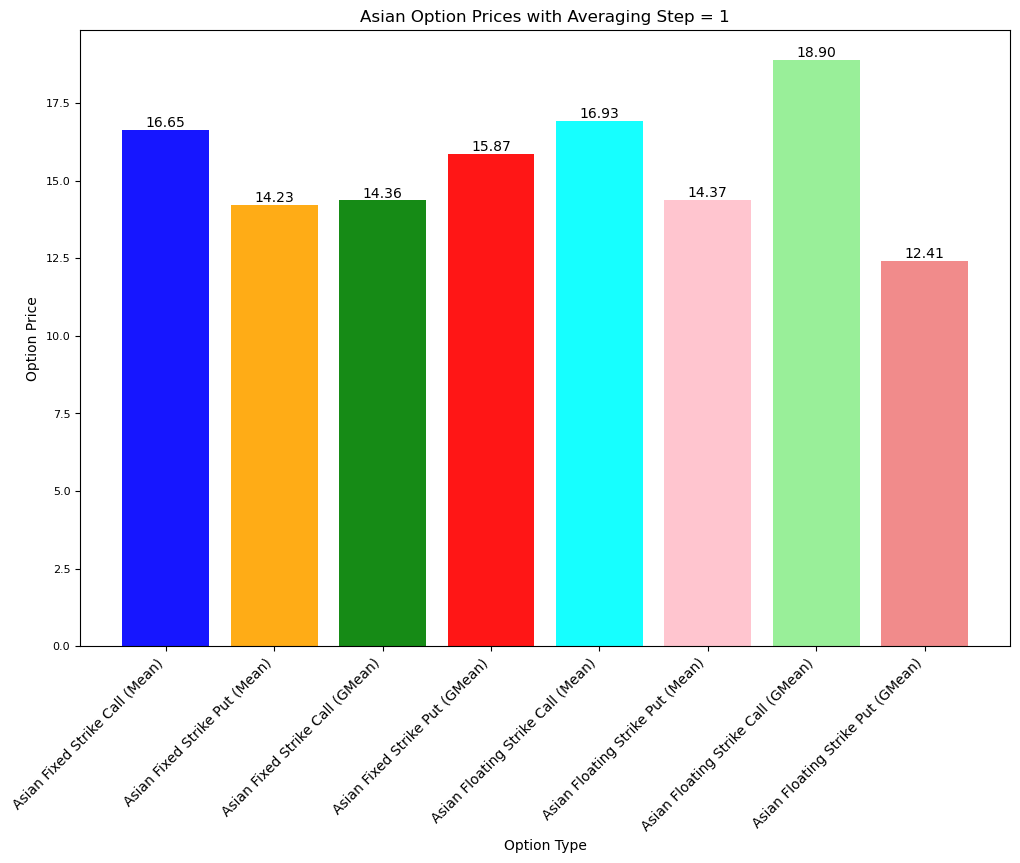

In [695]:
second_visualisation(stock_paths_increased_vol)

#### Results Discussion

Now comparing each pair of same type option between Mean and Geometric Mean, we see an even greater gap.

- Looking at Asian Fixed Strike Call (Mean and Geometric Mean) again.
    - We see the gap between these two has drastically increased. Our volatility is higher so our Arithmetic mean has been skewed even further upwards than with a volatility of 0.2, resulting in an even larger gap between the option prices.
        - Again, the reason for this skewing upwards, and the geometric being less affected, can be seen in [5].

Perhaps based on the purposes and environment, you should consider what type of averaging to use.

# Conclusion

To conclude, we have seen the general framework for the Monte-Carlo Simulation, and we have applied this to Asian Fixed and Floating strike options, as well as Supershare options. For the Asian options, we have used three different averaging techniques: arithmetic mean (normal averaging), geometric mean, and arithmetic mean with time between averaging steps (special averaging)

We then moved onto the Results section where we compared the 3 averages, the cost of Asians depending on risk-free rate, and more. For the future, we could produce more results and check how every single simulation paramater changes the behavior of the option price, however due to lack of time and feasability just some important examples were considered.



# References
[1] Ahmad, R. (2023). Numerical Methods Slides. Quantitative Methods in Finance, King's College London.

[2] Ahmad, R. (2023). Exotics (annotated) Slides. Quantitative Methods in Finance, King's College London.

[3] de Keijzer, B. (2023). Monte Carlo Simulation for Option Pricing(notes). Scientific Computing for Finance, King's College London. 

[4] Li, P. (2019). Pricing Exotic Options under Stochastic Volatility Models, Equation 11. XXII. URL : https://dspace5.zcu.cz/bitstream/11025/36039/1/Li.pdf

[5] heropup. (2020). Why is the geometric mean less sensitive to outliers than the arithmetic mean?. math.stackexchange. URL : https://math.stackexchange.com/questions/3609101/why-is-the-geometric-mean-less-sensitive-to-outliers-than-the-arithmetic-mean